In [657]:
import hdf5storage
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from analysis_util import *
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib.ticker import MaxNLocator


import seaborn as sns
'''this script test the hypothesis whether people respond to a fixed bound
pepole  '''
# global setting f
plt.rcParams.update({"font.size": 18})
colors = sns.color_palette("deep")
sns.set(style="whitegrid")
# top level dir 
# 


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression

In [658]:

PROJECT_DIR = "/data/rwchain-all/round2"
BEH_DIR = os.path.join(PROJECT_DIR, "rwchain-beh/data")
EEG_DIR = os.path.join(PROJECT_DIR, "rwchain-eeg")
ALL_BEH_DIR = os.path.join(PROJECT_DIR, 'rwchain-beh', 'combined')


In [659]:
CODE_DIR = "/home/jenny/evidence-chain/"
FIG_DIR = os.path.join(CODE_DIR, "figs/rw_evidence_locked_logit/")

In [660]:
stimdur = '250'

In [661]:

list_of_subj = os.listdir(BEH_DIR)
list_of_subj.sort()
# list_of_subj = [list_of_subj[5]]

df = pd.read_pickle(os.path.join(ALL_BEH_DIR, 'all_df_concat.pkl'))
# organize some columsn
 
df['key'][df['key'] == '[5]'] = 1
df['key'][df['key'] == '[3]'] = 1
df['key'][df['key'] == '[2]'] = 0
df['cumsum'] = df['sequence_clean'].apply(lambda x: [sum(x[:i+1]) for i in range(len(x))])

# get rid of a ;pw acc subject
df = df[df['sid']!='s108']

if stimdur == '100':
    df = df[df['stimDur'] == 0.1]
if stimdur == '250':
    df = df[df['stimDur'] == 0.25]
# df = df[df['stimDur'] != 0.5]
# df = df[df['stimDur'] != 0.05]
# df = df[df['stimDur'] == 0.1]



/tmp/ipykernel_580526/100844696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[5]'] = 1
/tmp/ipykernel_580526/100844696.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[3]'] = 1
/tmp/ipykernel_580526/100844696.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[2]'] = 0


In [662]:
# correct the count
df = correct_samples_by_condition(df)

cumsum = np.array(df['cumsum'].to_list())
sequence =  np.array(df['sequence_clean'].to_list())
count = df['count_corrected'].to_numpy()

In [663]:
df.shape

(3400, 13)

In [664]:
df.head()


,time,bytetime,press,count,key,stimDur,Bias,sequence,block,sequence_clean,sid,cumsum,count_corrected
0,2.6166679859161377,2611,[1],10,0,0.25,0.12,[-1. 1. -1. 1. -1. 1. -1. -1. -1. -1. -1. ...,0,"[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, ...",s102,"[-1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -2.0, ...",9
1,2.2499890327453613,2233,[1],8,1,0.25,0.12,[-1. -1. -1. 1. 1. 1. 1. 1. -1. -1. -1. -...,0,"[-1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1...",s102,"[-1.0, -2.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ...",7
2,2.1333320140838623,2118,[1],8,0,0.25,0.12,[ 1. -1. -1. -1. 1. 1. -1. -1. -1. -1. 1. ...,0,"[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, ...",s102,"[1.0, 0.0, -1.0, -2.0, -1.0, 0.0, -1.0, -2.0, ...",7
3,1.2833738327026367,1270,[1],5,1,0.25,0.12,[ 1. 1. 1. 1. -1. 1. 1. -1. -1. -1. 1. -...,0,"[1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1....",s102,"[1.0, 2.0, 3.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, ...",4
4,2.3333139419555664,2318,[1],9,1,0.25,0.12,[-1. 1. -1. 1. 1. -1. 1. 1. 1. -1. -1. -...,0,"[-1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1....",s102,"[-1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 3.0...",8


In [665]:
count.max()

29

In [666]:
# create a matrix of +1 and -1 with NaNs if the chain terminates

chain_matrix = get_chain_matrix(sequence, count)


In [667]:

# set the fixed bound


position_range = np.arange(8,9)
e_level_list = [1,3,5]
TRUE_N = []
TOTAL_N = []
FPR_TRAIN =[]
FPR_TEST =[]
TPR_TRAIN=[]
TPR_TEST=[]
AUC_TRAIN =[]
AUC_TEST =[]
POSITION_OF_SAMPLES=[]
N_TRAIN =[]
N_TEST = []
COEF =[] 
INTERCEPT= []
AUC_THRESH_TRAIN = []
AUC_THRESH_TEST =[]

for position_terminate in position_range:
    for e_level in e_level_list:
        dataset, dataset_resp = make_dataset(position_terminate, count, chain_matrix)
        TRUE_N.append(dataset_resp.sum())
        TOTAL_N.append(len(dataset))
        x_train, x_test, y_train, y_test = train_test_split(
            dataset, dataset_resp, test_size=0.3, random_state=2024
        )

        # integrate evidence    
        x_train_evidence = get_abs_evidence(x_train)
        x_test_evidence = get_abs_evidence(x_test)
        
        ind_train = x_train_evidence[:,-1]==e_level
        ind_test = x_test_evidence[:,-1]==e_level
        
        x_train_evidence = x_train_evidence[ind_train]
        x_test_evidence = x_test_evidence[ind_test]
        N_TRAIN.append(len(x_train_evidence))
        N_TEST.append(len(x_test_evidence))

        y_train = y_train[ind_train]
        y_test =  y_test[ind_test]
        # predict prob

        mymodel=LogisticRegression(fit_intercept=False)

        mymodel.fit(x_train_evidence,y_train)


        y_pred_prob_train = mymodel.predict_proba(x_train_evidence)
        y_pred_prob_test = mymodel.predict_proba(x_test_evidence)

        # plot ROC
        fpr_train, tpr_train, thresh_train = metrics.roc_curve(y_train, y_pred_prob_train[:,1])
        fpr_test, tpr_test, thresh_test = metrics.roc_curve(y_test, y_pred_prob_test[:,1])
        auc_train = metrics.auc(fpr_train, tpr_train)
        auc_test = metrics.auc(fpr_test, tpr_test)
        
        
        FPR_TRAIN.append(fpr_train)
        FPR_TEST.append(fpr_test)
        TPR_TRAIN.append(tpr_train)
        TPR_TEST.append(tpr_test)
        AUC_TRAIN.append(auc_train)
        AUC_TEST.append(auc_test)
        POSITION_OF_SAMPLES.append(position_terminate)
        AUC_THRESH_TRAIN.append(thresh_train)
        AUC_THRESH_TEST.append(thresh_test)
        COEF.append(mymodel.coef_)
        INTERCEPT.append(mymodel.intercept_)
    # plt.scatter(x_train_evidence,y_pred_prob_train)
    # plt.show()


In [668]:
GMEANS_train=[]
IDX_train=[]
for i in range(len(TPR_TRAIN)):
    gmeans = np.sqrt(TPR_TRAIN[i] * (1-FPR_TRAIN[i]))
    ix = np.argmax(gmeans)
    GMEANS_train.append(AUC_THRESH_TRAIN[i][ix])
    IDX_train.append(ix)
    

In [669]:
GMEANS_test=[]
IDX_test=[]
for i in range(len(TPR_TEST)):
    gmeans = get_gmeans(TPR_TEST[i], FPR_TEST[i])
    ix = np.argmax(gmeans)
    GMEANS_test.append(AUC_THRESH_TEST[i][ix])
    IDX_test.append(ix)

In [670]:
# fig,ax = plot_roc(FPR_TRAIN[0:2],TPR_TRAIN[0:2],AUC_TRAIN[0:2], position_range[0:2]+1, N_TRAIN[0:2], auc_cutoff = 0.1)
# ax.scatter(FPR_TRAIN[0][IDX_train[0]], TPR_TRAIN[0][IDX_train[0]], color = 'red', lw = 4, label="optimal threshold using g-means")
# ax.scatter(FPR_TRAIN[1][IDX_train[1]], TPR_TRAIN[1][IDX_train[1]], color = 'red', lw = 4)
# ax.get_legend().remove()
# fig.legend(bbox_to_anchor=(0.6,1,1,0))
# fig.show()
# fig.savefig(f'{FIG_DIR}gmean_demo_{stimdur}.png', dpi=300, bbox_inches='tight')


In [671]:
position_range

array([8])

/tmp/ipykernel_580526/1751186534.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


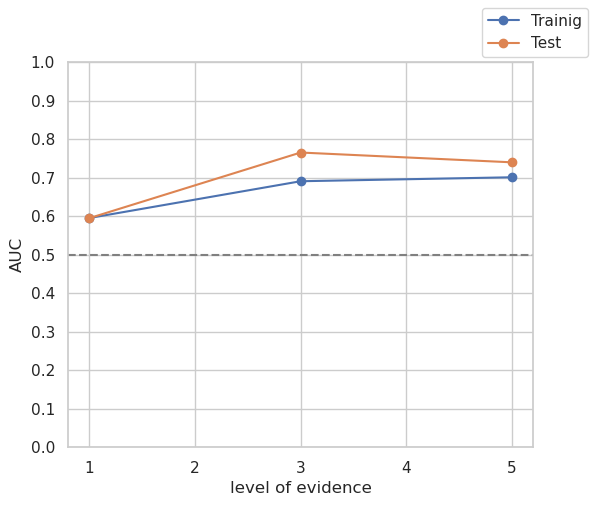

In [672]:
fig, ax = plot_roc_per_sample_position([i-1 for i in e_level_list], AUC_TRAIN, AUC_TEST)
ax.axhline(y=0.5, color ='grey', ls='--')
# ax.set_xticks([i+1 for i in POSITION_OF_SAMPLES])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_yticks(np.arange(0,1.1,0.1))
fig.set_size_inches(6, 5)
ax.set_xlabel('level of evidence')
fig.savefig(f'{FIG_DIR}auc_lines_{stimdur}_pos{position_range[0]}.png', dpi=300,bbox_inches='tight')

fig.show()

In [673]:
# fig, ax = plt.subplots(1,1)
# ax.plot(position_range+1, [i for i in GMEANS_train], linewidth=5, marker = 'X', alpha=0.6, color='blue', label = 'Training')
# ax.plot(position_range+1, [i for i in GMEANS_test], marker = 'o', alpha=0.6, color= 'red', label = 'Test')
# ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set_xlabel("Samples")
# ax.set_ylabel("Optimal Threshold \n gmean")

# # ax.set_ylim(1,10)
# fig.legend()
# fig.tight_layout()
# fig.savefig(f'{FIG_DIR}threshold_per_sample_{stimdur}.png', dpi=300,bbox_inches='tight')
# fig.show()



In [674]:
position_range[0]

8

/tmp/ipykernel_580526/2292060914.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


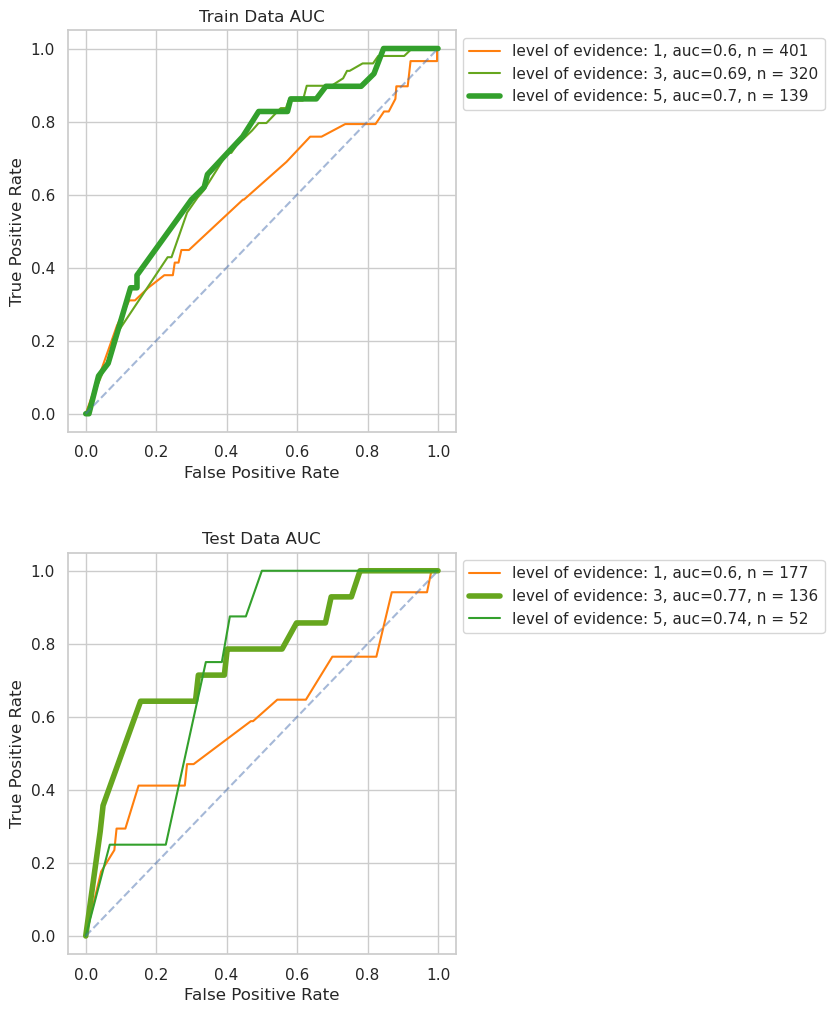

In [675]:
fig, ax = plt.subplots(2,1,figsize = (5,12))
_,ax0 = plot_roc(FPR_TRAIN,TPR_TRAIN,AUC_TRAIN, e_level_list, N_TRAIN, auc_cutoff = 0, ax=ax[0], label="level of evidence")
_,ax1 = plot_roc(FPR_TEST,TPR_TEST,AUC_TEST, e_level_list, N_TEST, auc_cutoff = 0, ax=ax[1],label="level of evidence")
ax0.set_title("Train Data AUC")
ax1.set_title("Test Data AUC")
fig.subplots_adjust(hspace=0.3)
fig.show()
fig.savefig(f'{FIG_DIR}auc_curve_{stimdur}_pos{position_range[0]}.png', dpi=300,bbox_inches='tight')



In [676]:
position_range

array([8])

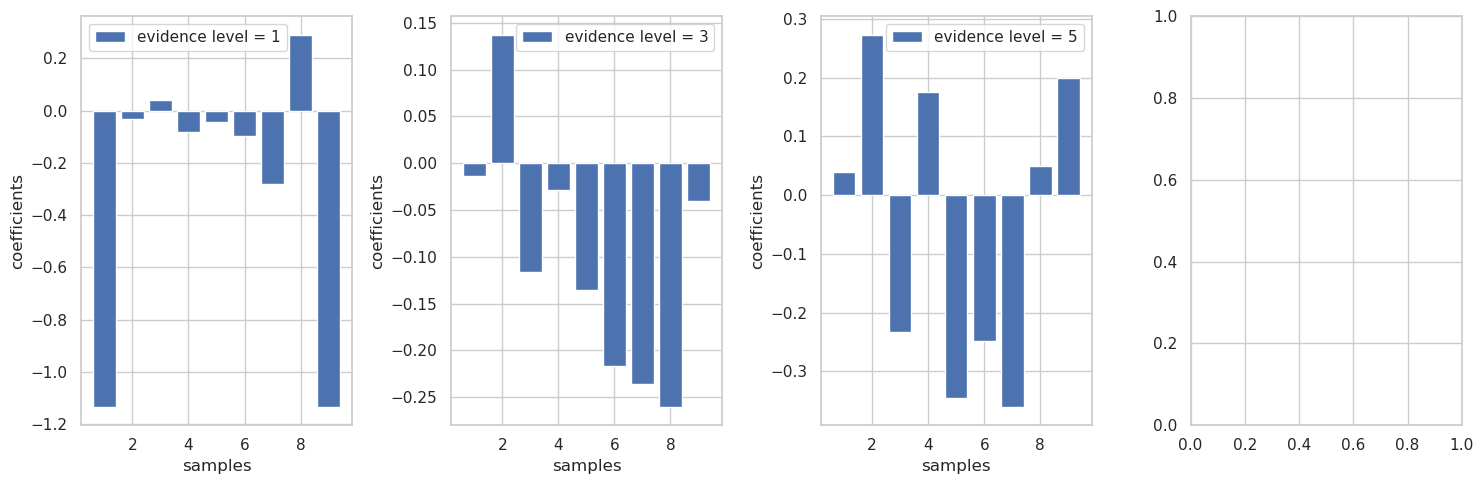

In [677]:
fig, ax= plt.subplots(1,4,figsize = (15,5))
for ind, j in enumerate(COEF):
    ax[ind].bar(np.arange(1,position_range[0]+2),j[0], label = f'evidence level = {e_level_list[ind]}')

    ax[ind].set_xlabel('samples')
    ax[ind].set_ylabel('coefficients')
    ax[ind].legend()
fig.tight_layout()
fig.savefig(f'{FIG_DIR}coefficients_{stimdur}_pos{position_range[0]}.png', dpi=300,bbox_inches='tight')
